## Import Statments

In [1]:
#Imports
#Data processing
import pandas as pd
import numpy as np

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#ML libs
from sklearn.impute import KNNImputer

## Import Data

In [2]:
#Import features of each production well into dfProd
dfProd = pd.read_csv((r"../well_data/wellbore_data_producer_wells.csv"))

## Data Prep

Instead of KNN or overall mean imputation, the following values should have a value that can be determined as an average over the entire well and applied (well-by-well imputation)

In [3]:
avg_features = ["Porosity, fraction", "Permeability, mD", "Compressible velocity, m/s","Youngs modulus, GPa", "Shear modulus, GPa","Shear velocity, m/s"]
avg_dict = {k:"mean" for k in avg_features}
dfProd["Well_ID"] = dfProd["Well_ID"].str[8:].astype(int)
dfWellAvg = dfProd.groupby(dfProd["Well_ID"]).agg(avg_dict)
print(dfWellAvg)
dfWellAvg.isna().sum()

         Porosity, fraction  Permeability, mD  Compressible velocity, m/s  \
Well_ID                                                                     
1                  0.133426        189.116974                 3392.897466   
2                  0.128885        176.367428                 3514.562352   
3                  0.118062        119.421584                 3972.826143   
4                  0.138111        151.595670                 3675.865373   
5                  0.130910        123.891145                 3790.337407   
...                     ...               ...                         ...   
69                 0.124074        166.810299                 3996.551094   
70                 0.139168        201.311447                 3308.578249   
71                 0.133675        105.286049                 3649.363331   
72                 0.109639         48.529438                 3899.275259   
73                 0.129752        101.693127                 3758.822664   

Porosity, fraction            0
Permeability, mD              0
Compressible velocity, m/s    0
Youngs modulus, GPa           0
Shear modulus, GPa            0
Shear velocity, m/s           0
dtype: int64

In [4]:
# Checking to make sure that nothing has an average value of 0 for anything, as that may mean that all values were NaN for a well
dfWellAvg.describe()
#Looks like we're okay

,"Porosity, fraction","Permeability, mD","Compressible velocity, m/s","Youngs modulus, GPa","Shear modulus, GPa","Shear velocity, m/s"
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,0.127886,113.409308,3692.465430,27.306561,5.751262,1676.124958
std,0.011534,53.227536,275.928692,2.132350,0.447604,22.791342
min,0.103266,17.692998,3226.716917,23.926022,4.952945,1629.142399
25%,0.119792,77.784480,3444.442189,25.499713,5.331215,1657.608521
50%,0.128884,99.067583,3688.453880,27.021138,5.708991,1676.017976
75%,0.134574,141.908305,3906.539696,29.041203,6.137787,1690.990515
max,0.163979,262.406426,4355.738959,31.787065,6.593852,1727.196584


In [5]:
WellAvgdict = dfWellAvg.to_dict()

In [6]:
dfProd["Rock facies"].unique()

array(['Sandstone', 'Sandy shale', 'Shaly sandstone', nan, 'Shale'],
      dtype=object)

In [7]:
ordinal_mapper = {'Sandstone': 4, 'Sandy shale': 3, 'Shaly sandstone': 2, 'Shale': 1}
dfProd['Rock facies'] = dfProd['Rock facies'].replace(ordinal_mapper)

In [8]:
dfProd.dtypes

Well_ID                           int32
X, m                              int64
Y, m                              int64
Depth, m                        float64
Porosity, fraction              float64
Permeability, mD                float64
Acoustic Impedance, kg*s/m^2    float64
Rock facies                     float64
Density, g/cm3                  float64
Compressible velocity, m/s      float64
Youngs modulus, GPa             float64
Shear velocity, m/s             float64
Shear modulus, GPa              float64
dtype: object

## Imputation

In [9]:
dfWellAvg.loc[1]

Porosity, fraction               0.133426
Permeability, mD               189.116974
Compressible velocity, m/s    3392.897466
Youngs modulus, GPa             25.674891
Shear modulus, GPa               6.357954
Shear velocity, m/s           1656.844649
Name: 1, dtype: float64

In [10]:
imputer = KNNImputer(n_neighbors=3)

In [11]:
dfProd.describe()

,Well_ID,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
count,1460.000000,1460.000000,1460.000000,1460.000000,1268.000000,284.000000,1.357000e+03,1330.000000,1248.000000,1276.000000,1261.000000,1270.000000,1285.000000
mean,37.000000,4188.698630,5770.890411,3055.810959,0.127746,112.182739,7.325786e+06,2.971429,2.052521,3688.657853,27.288877,1676.158075,5.752640
std,21.078527,1771.495039,2389.773641,4.353335,0.036020,80.894436,3.101125e+05,1.081660,0.417622,727.216238,5.424608,100.630094,1.518699
min,1.000000,1175.000000,775.000000,3045.620000,0.040270,2.214604,6.559277e+06,1.000000,1.421943,1661.828496,13.205134,1307.887097,1.650985
25%,19.000000,2925.000000,3825.000000,3052.720000,0.113953,51.540980,7.111056e+06,2.000000,1.734052,3178.389486,23.466538,1608.928309,4.757475
50%,37.000000,3875.000000,6125.000000,3055.790000,0.137495,93.980722,7.274333e+06,3.000000,1.988542,3664.196826,26.647466,1674.836574,5.610267
75%,55.000000,5325.000000,7625.000000,3058.982500,0.152325,154.584890,7.503378e+06,4.000000,2.229507,4214.924966,30.874629,1746.081251,6.600503
max,73.000000,7975.000000,9775.000000,3066.300000,0.188910,489.219402,8.249272e+06,4.000000,3.530373,6179.653016,48.123292,1989.829247,11.820038


In [12]:
dfProd.isna().sum()

Well_ID                            0
X, m                               0
Y, m                               0
Depth, m                           0
Porosity, fraction               192
Permeability, mD                1176
Acoustic Impedance, kg*s/m^2     103
Rock facies                      130
Density, g/cm3                   212
Compressible velocity, m/s       184
Youngs modulus, GPa              199
Shear velocity, m/s              190
Shear modulus, GPa               175
dtype: int64

In [13]:
X = dfProd.drop("Well_ID", axis=1)

In [14]:
dfProdimputed = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)

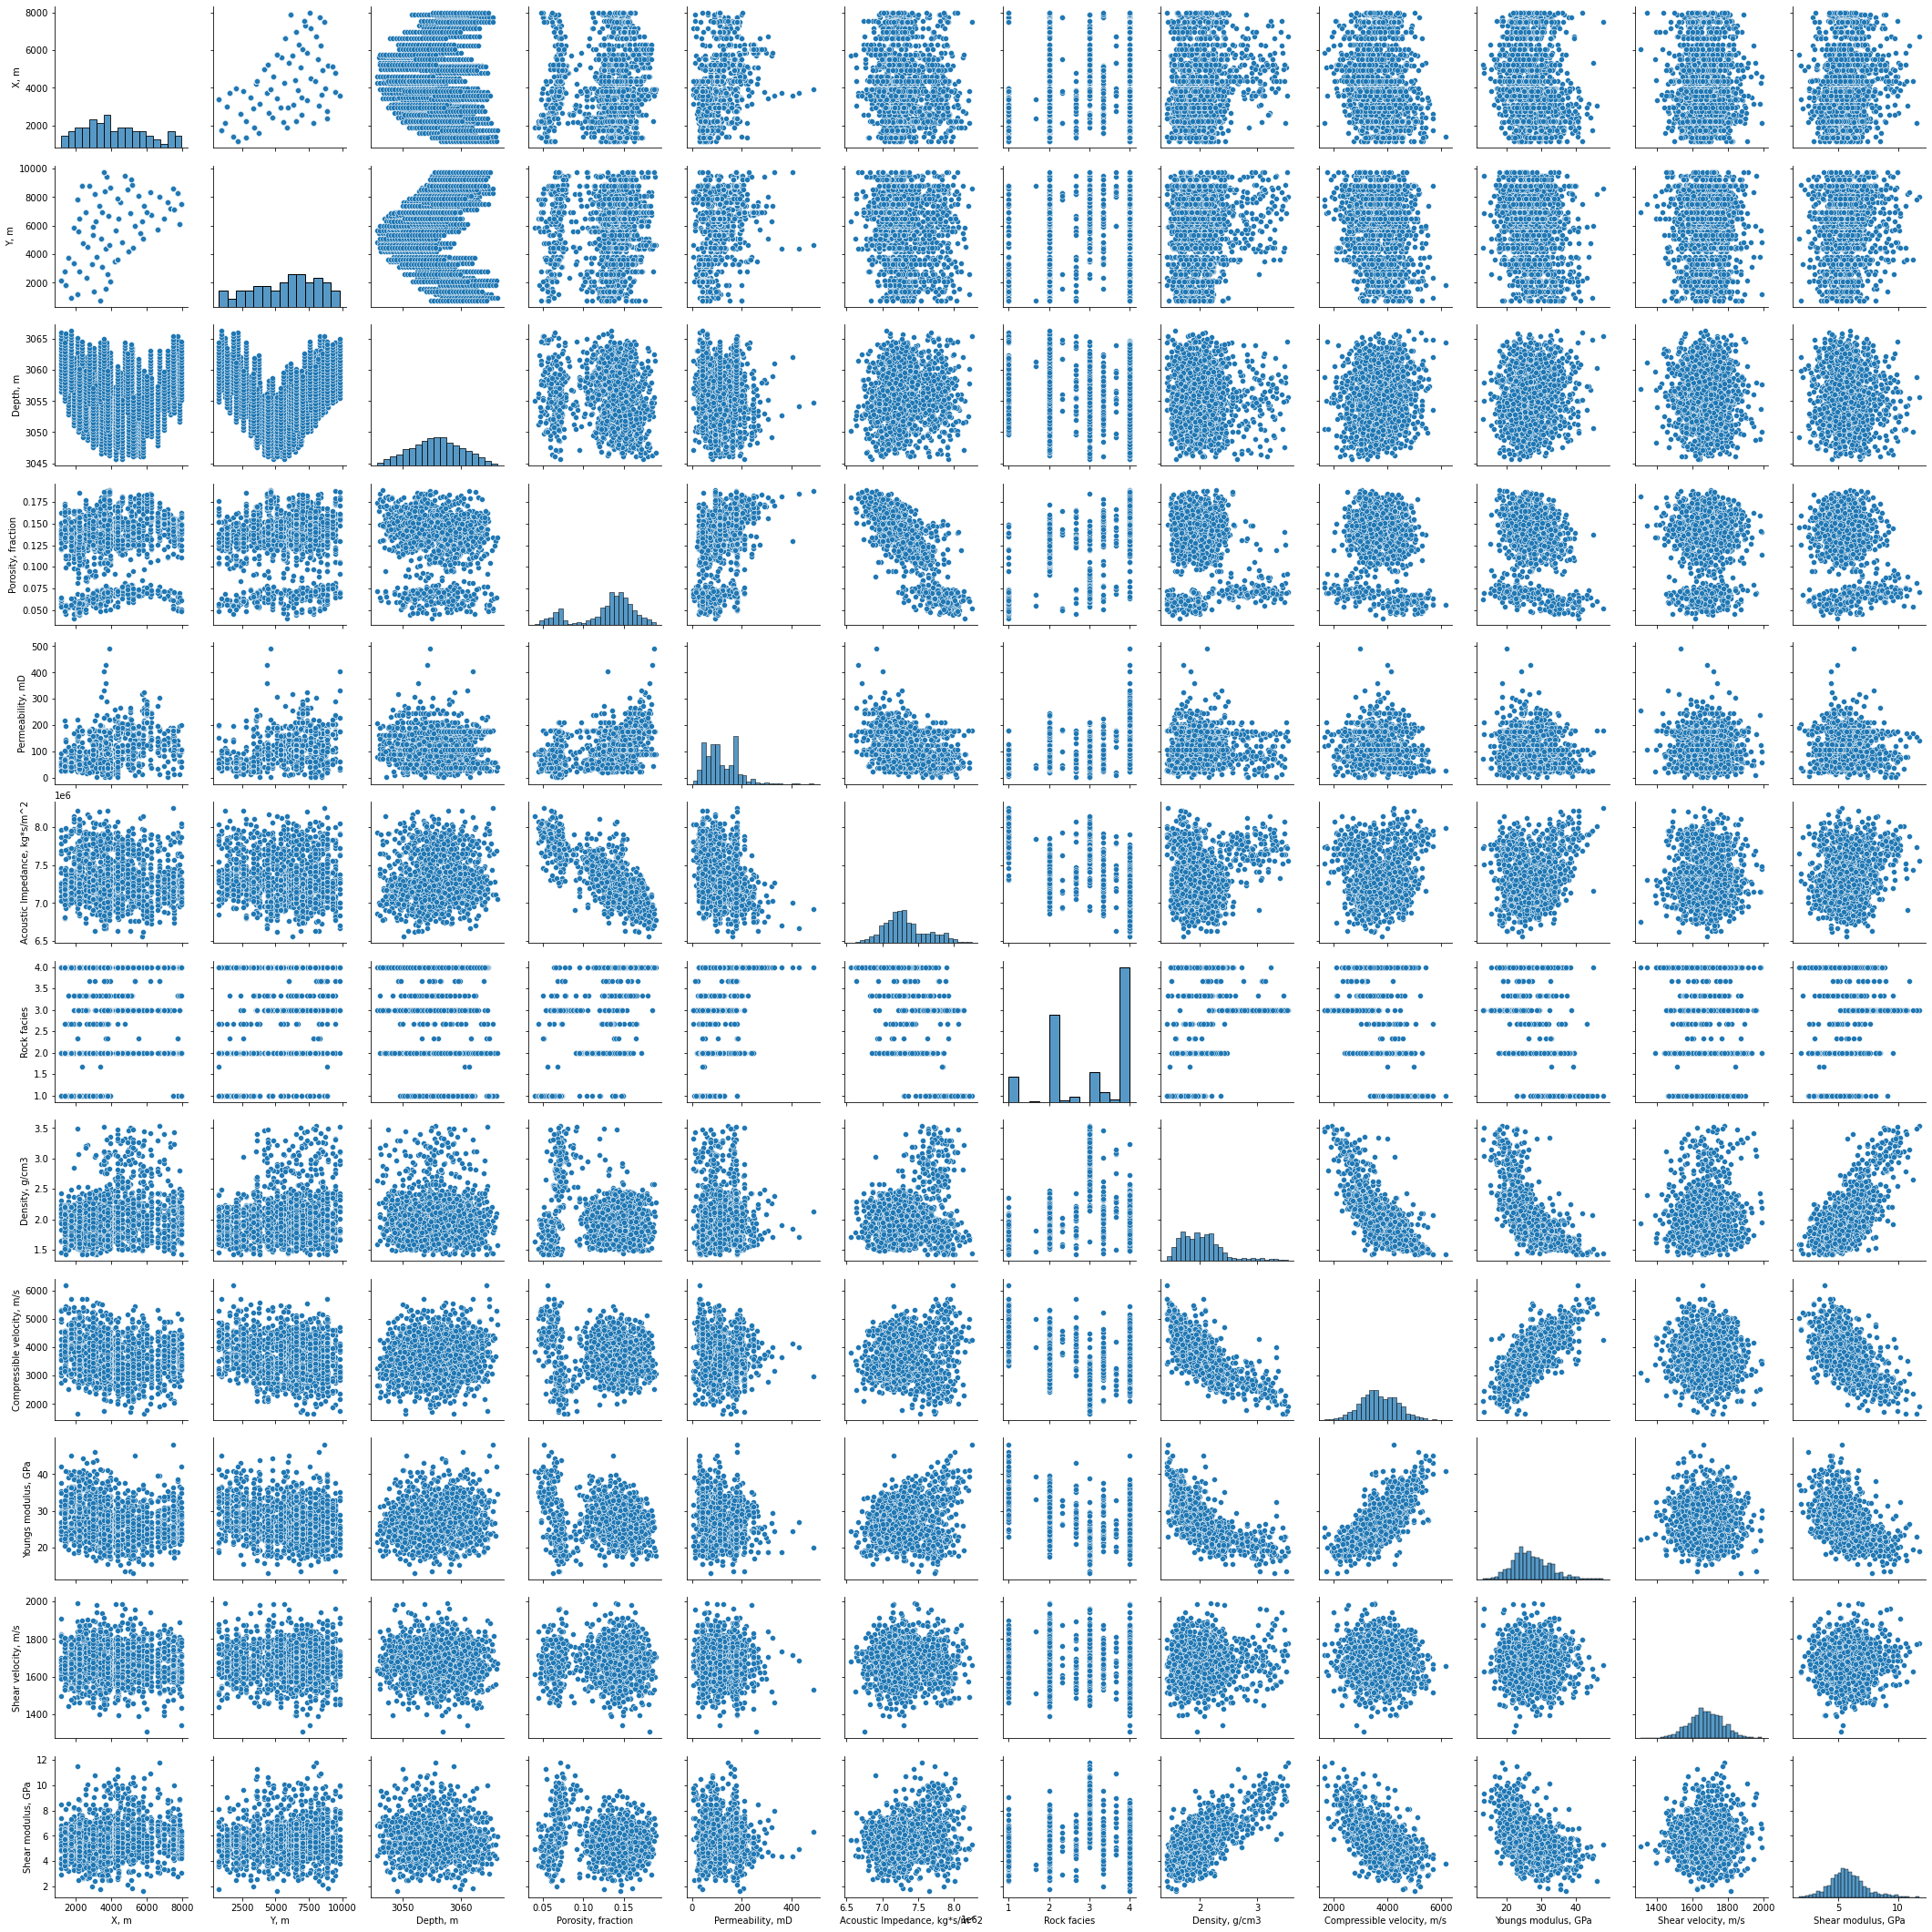

In [15]:
sns.pairplot(dfProdimputed)